# Lithology Prediction from Well logs

This project employs a typical ML workflow; from data preparation to model evaluation.

**Aim**: To predict lithology (rock types) of a drilled Well using its provided geophysical logs and labelled cores

**Objectives**

* Import full data and select data for use
* Visualize well data
* Train machine learning model
* Evaluate machine learning prediction

### Import libraries and load Wells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as sklm
import petroeval as pet
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [2]:
data = pd.read_csv('./data/lithofacies1.csv')
data.head(2)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.61141,...,34.63641,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.61807,...,34.63641,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0


### Data Selection

In [3]:
# selecting well to be used
data = data.loc[data.WELL == '15/9-13']
data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18265,15/9-13,3271.416,437593.40625,6470983.0,-3245.549316,ZECHSTEIN GP.,Smith Bank Fm.,8.541623,NaN,8.585064,...,1.524012,NaN,NaN,-0.005047,0.155774,NaN,NaN,NaN,74000,3.0
18266,15/9-13,3271.568,437593.37500,6470983.0,-3245.700928,ZECHSTEIN GP.,Smith Bank Fm.,8.557213,NaN,8.142556,...,2.056166,NaN,NaN,0.002087,0.155774,NaN,NaN,NaN,74000,3.0
18267,15/9-13,3271.720,437593.37500,6470983.0,-3245.852539,ZECHSTEIN GP.,Smith Bank Fm.,8.577917,NaN,7.933336,...,2.909438,NaN,NaN,0.007469,0.155774,NaN,NaN,NaN,74000,3.0
18268,15/9-13,3271.872,437593.37500,6470983.0,-3246.004395,ZECHSTEIN GP.,Smith Bank Fm.,8.478219,NaN,7.837981,...,2.909438,NaN,NaN,0.010048,0.155774,NaN,NaN,NaN,74000,3.0


The original is from a field with multiple lithofacies, the data is prepared to extract points corresponding only to sandstone and shale formations.

In [4]:
data.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    12547
30000     2937
70000     1418
65030      708
80000      429
99000      173
74000       41
86000       17
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [5]:
df_sandstone = data.loc[data.FORCE_2020_LITHOFACIES_LITHOLOGY == 30000]
df_shale = data.loc[data.FORCE_2020_LITHOFACIES_LITHOLOGY == 65000]

In [6]:
# concatenating both dataframes

df = pd.concat((df_sandstone, df_shale))
df.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    12547
30000     2937
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [7]:
# reordering the dataframe by depth 
df = df.sort_values(by='DEPTH_MD')
df

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18207,15/9-13,3262.600,437593.93750,6470983.0,-3236.750732,ZECHSTEIN GP.,Smith Bank Fm.,8.538301,NaN,7.329019,...,4.291701,NaN,NaN,-0.009892,0.155774,NaN,NaN,NaN,65000,1.0
18208,15/9-13,3262.752,437593.93750,6470983.0,-3236.902344,ZECHSTEIN GP.,Smith Bank Fm.,8.546900,NaN,7.756433,...,4.088065,NaN,NaN,-0.016560,0.155774,NaN,NaN,NaN,65000,1.0
18209,15/9-13,3262.904,437593.93750,6470983.0,-3237.054199,ZECHSTEIN GP.,Smith Bank Fm.,8.540575,NaN,8.140708,...,3.606302,NaN,NaN,-0.015262,0.155774,NaN,NaN,NaN,65000,1.0
18210,15/9-13,3263.056,437593.90625,6470983.0,-3237.205811,ZECHSTEIN GP.,Smith Bank Fm.,8.526410,NaN,8.324627,...,3.119861,NaN,NaN,-0.014277,0.155774,NaN,NaN,NaN,65000,1.0


In [8]:
# preparing the classification labels for the ML algorithms
lithology_numbers = {30000: 0,
                     65000: 1}

df.FORCE_2020_LITHOFACIES_LITHOLOGY = (df.FORCE_2020_LITHOFACIES_LITHOLOGY).map(lithology_numbers)

In [9]:
print(df.shape)
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 

df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes 

print(df.shape)

(15484, 29)
(15484, 31)


In [10]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)

In [11]:
# Writing a function to plot the well logs

def make_facies_log_plot(logs, x1, x2, x3, x4, x5):

    #logs = logs.fillna(0)        
    logs = logs.sort_values(by='DEPTH_MD', ascending=True)
    ztop = logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    facies_colors = [
        '#F4D03F', '#F5B041'
    ]

    facies_labels = [
        'Sandstone', 'Shale'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.DEPTH_MD, '-g')
    ax[1].plot(logs[x2], logs.DEPTH_MD, '-')
    ax[2].plot(logs[x3], logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs[x4], logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs[x5], logs.DEPTH_MD, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((7*' ').join([
        'Sandstone', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel(x1)
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])

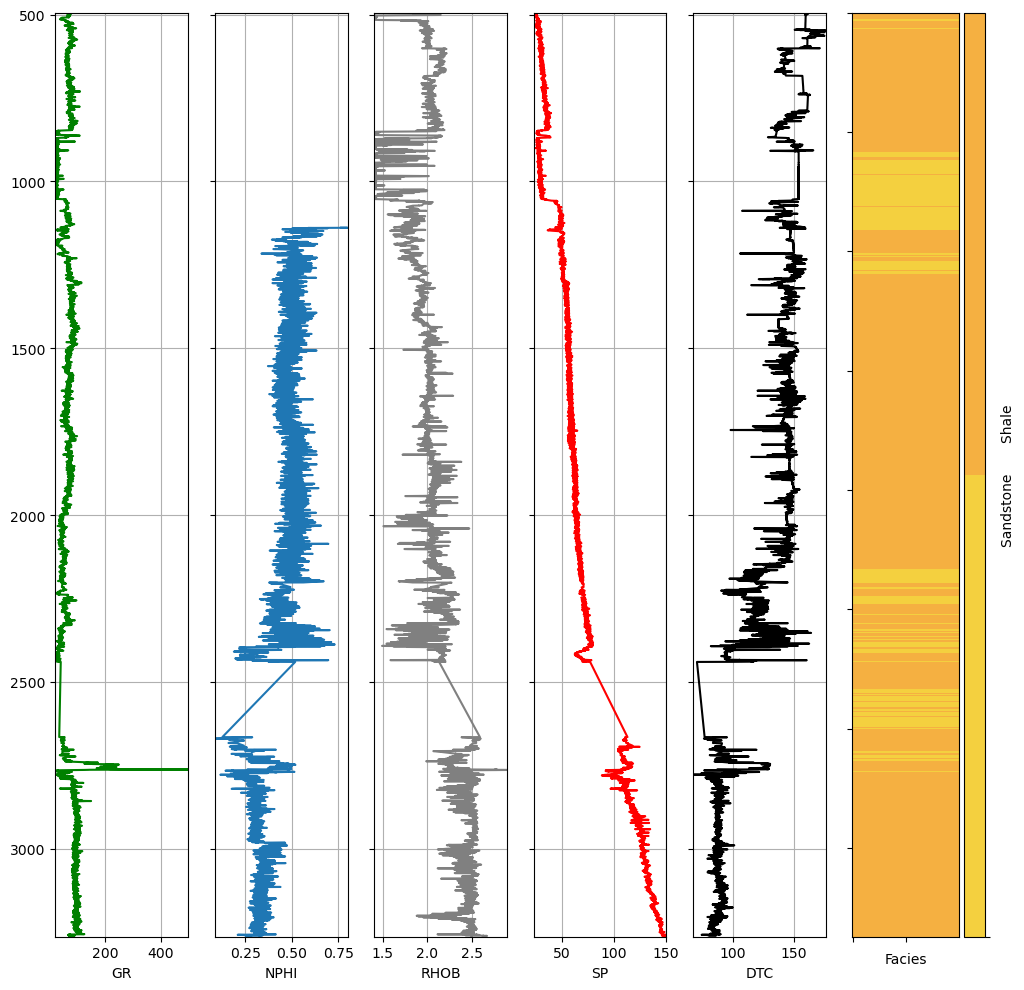

In [12]:
make_facies_log_plot(df, 'GR', 'NPHI', 'RHOB', 'SP', 'DTC')

In [13]:
# selecting and extracting the section to be predicted

section = df.loc[(df.DEPTH_MD >= 2300) & (df.DEPTH_MD <= 2500)]
section.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

0    528
1    392
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

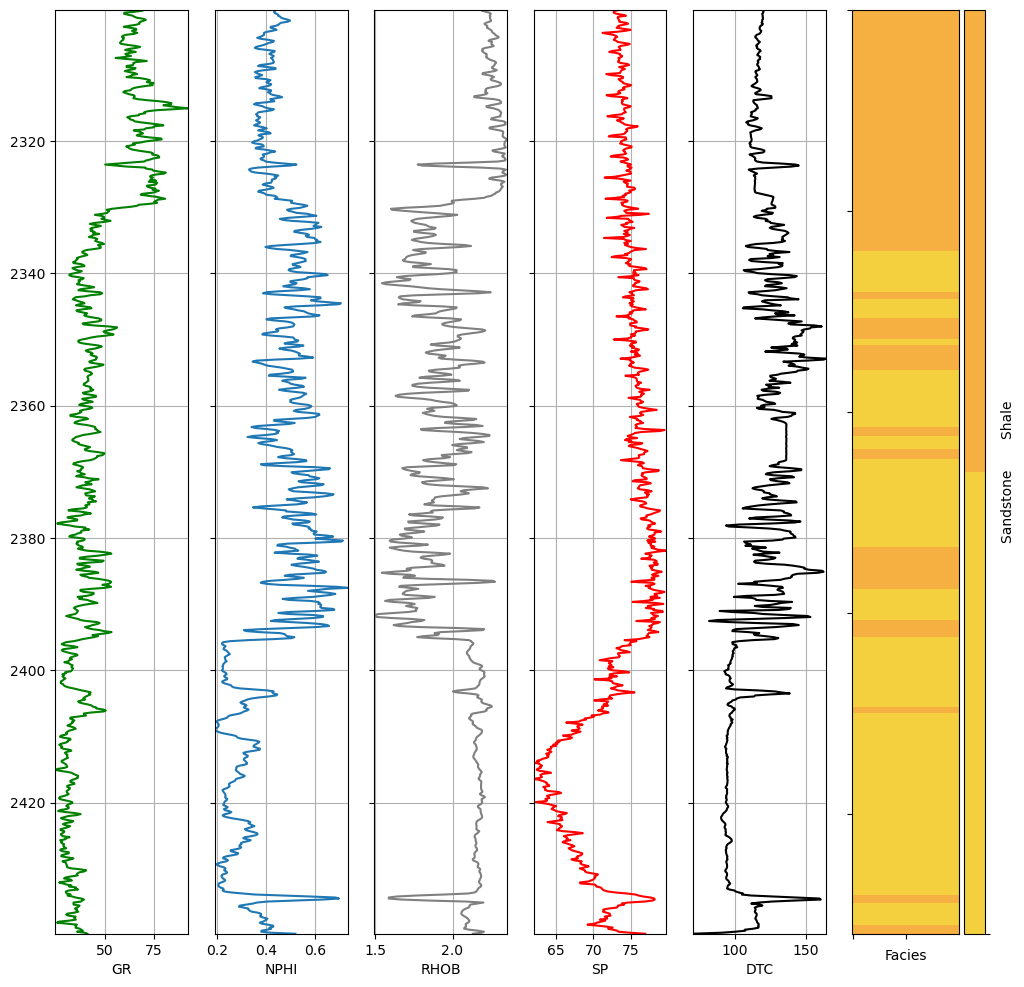

In [14]:
# plotting the section

make_facies_log_plot(section, 'GR', 'NPHI', 'RHOB', 'SP', 'DTC')

In [15]:
# making the train data after removing the test section

x_train1 = df.loc[(df.DEPTH_MD < 2300)]
x_train2 = df.loc[(df.DEPTH_MD > 2500)]
x_train = pd.concat((x_train1, x_train2))
x_train

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,...,NaN,-0.574928,NaN,NaN,NaN,NaN,1,1.0,2,-1
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,...,NaN,-0.570188,NaN,NaN,NaN,NaN,1,1.0,2,-1
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,...,NaN,-0.574245,NaN,NaN,NaN,NaN,1,1.0,2,-1
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,...,NaN,-0.586315,NaN,NaN,NaN,NaN,1,1.0,2,-1
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,...,NaN,-0.597914,NaN,NaN,NaN,NaN,1,1.0,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18207,3262.600,437593.93750,6470983.0,-3236.750732,8.538301,NaN,7.329019,8.044077,2.640455,71.512497,...,NaN,-0.009892,0.155774,NaN,NaN,NaN,1,1.0,7,9
18208,3262.752,437593.93750,6470983.0,-3236.902344,8.546900,NaN,7.756433,8.436756,2.640971,74.123634,...,NaN,-0.016560,0.155774,NaN,NaN,NaN,1,1.0,7,9
18209,3262.904,437593.93750,6470983.0,-3237.054199,8.540575,NaN,8.140708,8.792896,2.643762,77.131882,...,NaN,-0.015262,0.155774,NaN,NaN,NaN,1,1.0,7,9
18210,3263.056,437593.90625,6470983.0,-3237.205811,8.526410,NaN,8.324627,9.143516,2.631891,81.981567,...,NaN,-0.014277,0.155774,NaN,NaN,NaN,1,1.0,7,9


In [16]:
(x_train.isna().sum() / x_train.shape[0]) * 100

DEPTH_MD                               0.000000
X_LOC                                  0.000000
Y_LOC                                  0.000000
Z_LOC                                  0.000000
CALI                                   0.000000
RSHA                                  94.829717
RMED                                   0.000000
RDEP                                   0.000000
RHOB                                   0.000000
GR                                     0.000000
SGR                                  100.000000
NPHI                                  27.478715
PEF                                   11.349904
DTC                                    0.157924
SP                                     0.000000
BS                                   100.000000
ROP                                    0.405108
DTS                                  100.000000
DCAL                                 100.000000
DRHO                                   0.000000
MUDWEIGHT                              5

In [17]:
# dropping logs based on appearance in the well

x_train = x_train.drop(['RSHA', 'SGR', 'BS', 'DTS', 'DCAL', 'RMIC', 'ROPA', 'RXO'], axis=1)
section = section.drop(['RSHA', 'SGR', 'BS', 'DTS', 'DCAL', 'RMIC', 'ROPA', 'RXO'], axis=1)
y_train = np.array(x_train.FORCE_2020_LITHOFACIES_LITHOLOGY)

x_train.shape, y_train.shape

((14564, 20), (14564,))

In [18]:
labels = section.FORCE_2020_LITHOFACIES_LITHOLOGY

In [19]:
x_train.fillna(-9999, inplace=True)

In [20]:
x_train.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1, inplace=True)
section.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1, inplace=True)

### Training the classifier - Random Forest

In [21]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, verbose=2)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomForestClassifier(max_depth=20, verbose=2)

In [22]:
x_train.shape, section.shape

((14564, 19), (920, 19))

In [23]:
section.fillna(-9999, inplace=True)

### Prediction - Random forest

In [24]:
pred = rf.predict(section)
pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Evaluation - Random Forest

In [25]:
sklm.accuracy_score(labels, pred)

0.8532608695652174

In [26]:
sklm.recall_score(labels, pred)

0.6556122448979592

In [27]:
sklm.f1_score(labels, pred)

0.7919876733436055

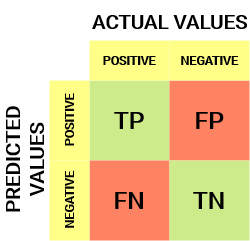

In [28]:
from IPython.display import Image
Image(filename='data/Basic-Confusion-matrix.png')

A confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model.

In [29]:
sklm.confusion_matrix(labels, pred)

array([[528,   0],
       [135, 257]], dtype=int64)

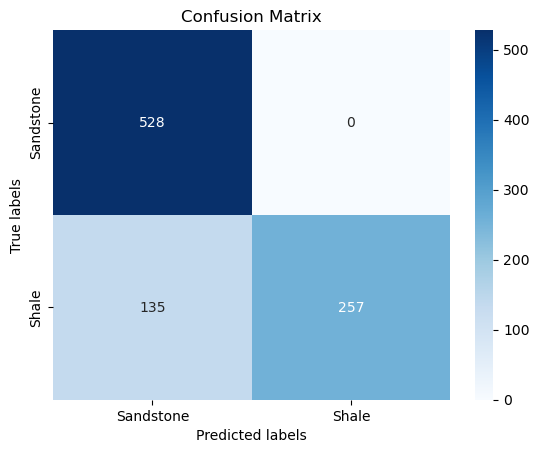

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the binary confusion matrix
cm = confusion_matrix(labels, pred, labels=[0, 1])

# Define class labels
class_labels = ["Sandstone", "Shale"]

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [31]:
section_ = section.copy()
section['FORCE_2020_LITHOFACIES_LITHOLOGY'] = labels
section['predictions'] = pred

In [32]:
def compare_facies_log_plot(logs, x1, x2, x3, x4, x5):
    
    #logs = logs.fillna(0)        
    logs = logs.sort_values(by='DEPTH_MD', ascending=True)
    ztop = logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    facies_colors = [
        '#F4D03F', '#F5B041'
    ]

    facies_labels = [
        'Sandstone', 'Shale'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['predictions'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.DEPTH_MD, '-g')
    ax[1].plot(logs[x2], logs.DEPTH_MD, '-')
    ax[2].plot(logs[x3], logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs[x4], logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs[x5], logs.DEPTH_MD, '-', color='r')
    im=ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    im=ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((7*' ').join([
        'Sandstone', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel(x1)
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Actual')
    ax[6].set_xlabel('Predictions')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); 

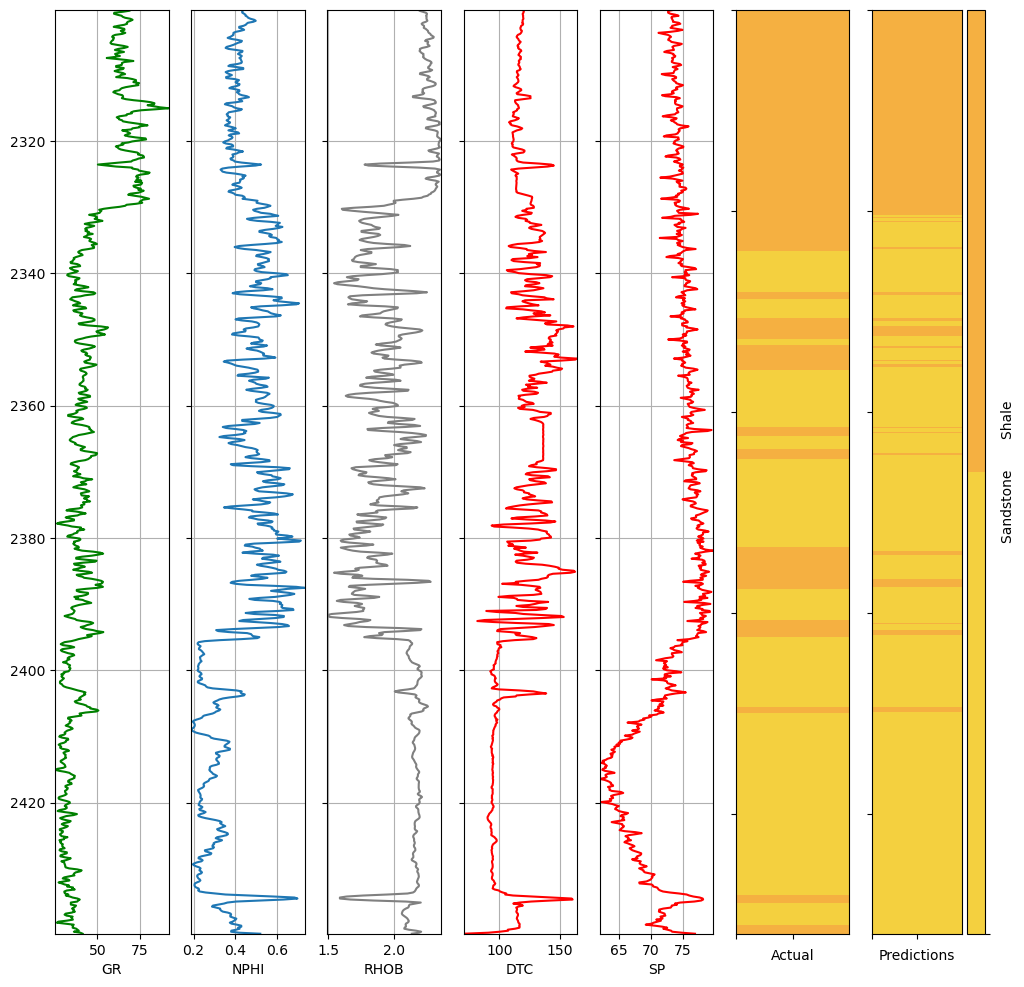

In [33]:
compare_facies_log_plot(section, 'GR', 'NPHI', 'RHOB', 'DTC', 'SP')

In [34]:
x_train

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,ROP,DRHO,MUDWEIGHT,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,-9999.000000,20.915468,161.131180,24.612379,34.636410,-0.574928,-9999.000000,1.0,2,-1
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,-9999.000000,19.383013,160.603470,23.895531,34.636410,-0.570188,-9999.000000,1.0,2,-1
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,-9999.000000,22.591518,160.173615,23.916357,34.779556,-0.574245,-9999.000000,1.0,2,-1
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,-9999.000000,32.191910,160.149429,23.793688,39.965164,-0.586315,-9999.000000,1.0,2,-1
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,-9999.000000,38.495632,160.128342,24.104078,57.483765,-0.597914,-9999.000000,1.0,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18207,3262.600,437593.93750,6470983.0,-3236.750732,8.538301,7.329019,8.044077,2.640455,71.512497,0.254717,-9999.000000,-9999.000000,149.005936,4.291701,-0.009892,0.155774,1.0,7,9
18208,3262.752,437593.93750,6470983.0,-3236.902344,8.546900,7.756433,8.436756,2.640971,74.123634,0.262474,-9999.000000,-9999.000000,149.095688,4.088065,-0.016560,0.155774,1.0,7,9
18209,3262.904,437593.93750,6470983.0,-3237.054199,8.540575,8.140708,8.792896,2.643762,77.131882,0.269714,-9999.000000,-9999.000000,148.888809,3.606302,-0.015262,0.155774,1.0,7,9
18210,3263.056,437593.90625,6470983.0,-3237.205811,8.526410,8.324627,9.143516,2.631891,81.981567,0.263887,-9999.000000,-9999.000000,149.097900,3.119861,-0.014277,0.155774,1.0,7,9


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score


### Training the classifier - Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=20)
dt.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=20)

### Prediction - Decision Tree

In [37]:
y_pred = dt.predict(section_)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Evaluation - Decision Tree

In [38]:
sklm.accuracy_score(labels, y_pred)

0.8380434782608696

In [39]:
sklm.recall_score(labels, y_pred)

0.6709183673469388

In [40]:
sklm.f1_score(labels, y_pred)

0.7792592592592593

In [41]:
sklm.confusion_matrix(labels, y_pred)

array([[508,  20],
       [129, 263]], dtype=int64)

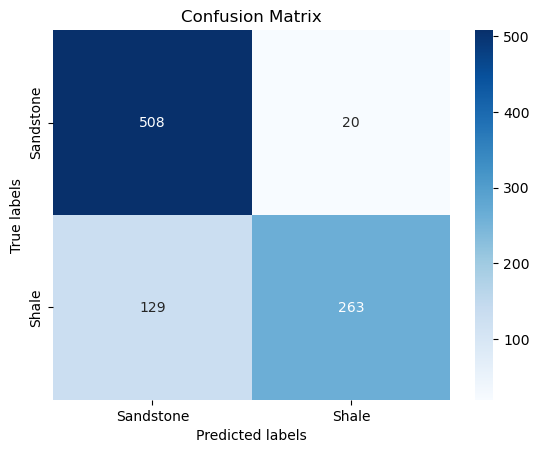

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the binary confusion matrix
cm = confusion_matrix(labels, y_pred, labels=[0, 1])

# Define class labels
class_labels = ["Sandstone", "Shale"]

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Training the classifier - XGBoost

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=20)
xgb.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Prediction - XGBoost

In [44]:
xgb_pred = xgb.predict(section_)
xgb_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Evaluation - XGBoost

In [45]:
sklm.accuracy_score(labels, xgb_pred)

0.8521739130434782

In [46]:
sklm.recall_score(labels, xgb_pred)

0.6632653061224489

In [47]:
sklm.f1_score(labels, xgb_pred)

0.7926829268292682

In [48]:
sklm.confusion_matrix(labels, xgb_pred)

array([[524,   4],
       [132, 260]], dtype=int64)

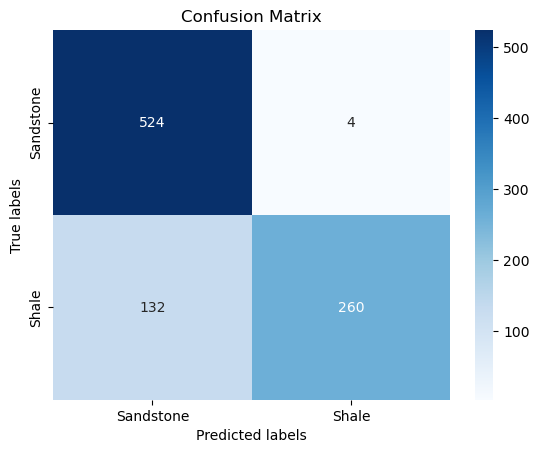

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the binary confusion matrix
cm = confusion_matrix(labels, xgb_pred, labels=[0, 1])

# Define class labels
class_labels = ["Sandstone", "Shale"]

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Model Comparisons

In [50]:
section['FORCE_2020_LITHOFACIES_LITHOLOGY'] = labels
section['rf_preds'] = pred
section['dt_preds'] = y_pred
section['xgb_preds'] = xgb_pred

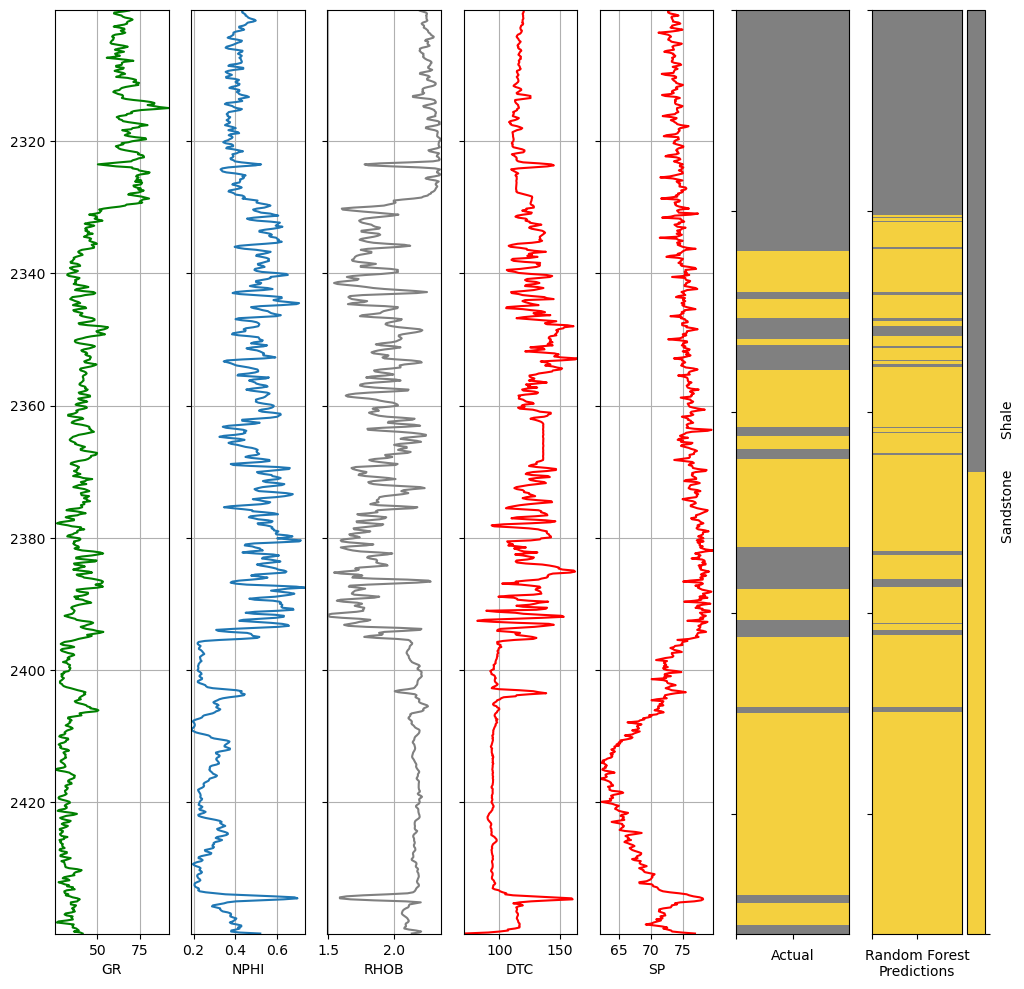

In [51]:
def compare_facies_log_plot(logs, x1, x2, x3, x4, x5):
    
    #logs = logs.fillna(0)        
    logs = logs.sort_values(by='DEPTH_MD', ascending=True)
    ztop = logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    facies_colors = [
        '#F4D03F', 'grey'
    ]

    facies_labels = [
        'Sandstone', 'Shale'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['rf_preds'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.DEPTH_MD, '-g')
    ax[1].plot(logs[x2], logs.DEPTH_MD, '-')
    ax[2].plot(logs[x3], logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs[x4], logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs[x5], logs.DEPTH_MD, '-', color='r')
    im=ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    im=ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((7*' ').join([
        'Sandstone', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel(x1)
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Actual')
    ax[6].set_xlabel('Random Forest\nPredictions')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); 
    
compare_facies_log_plot(section, 'GR', 'NPHI', 'RHOB', 'DTC', 'SP')

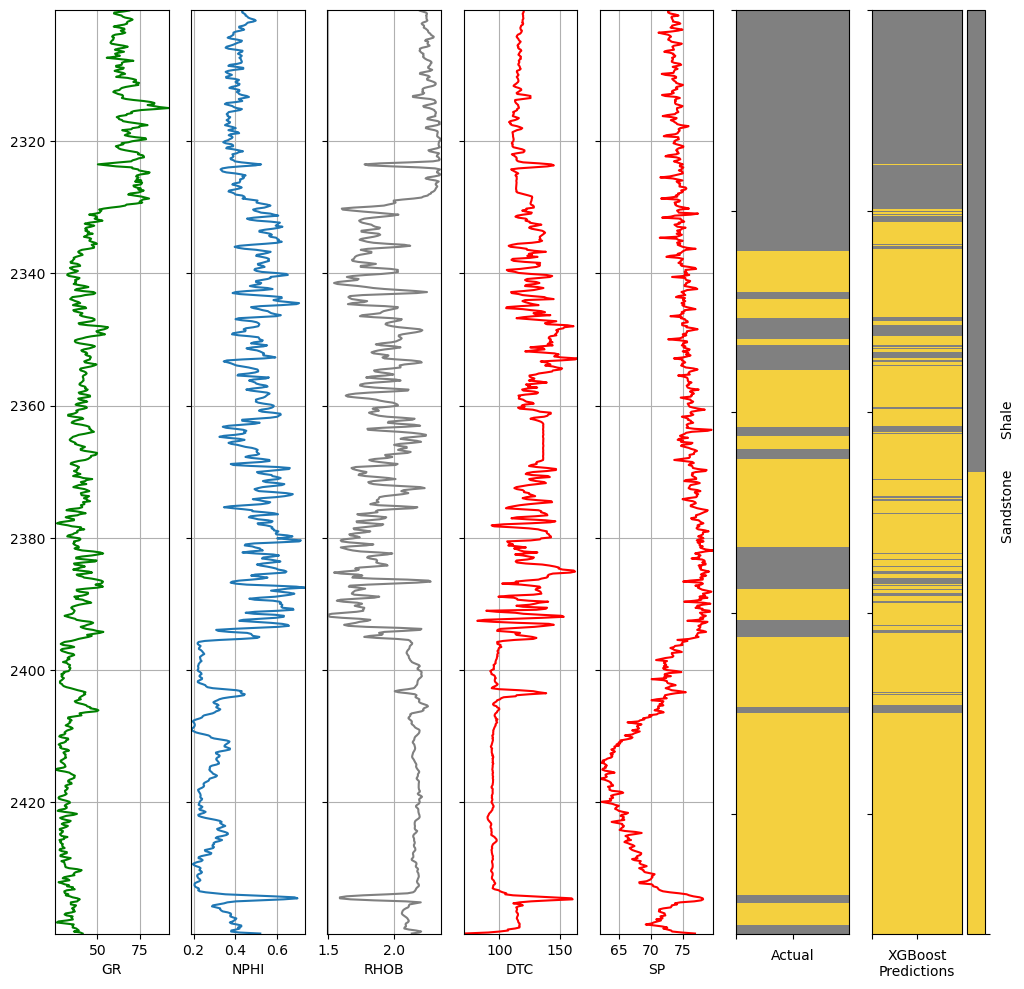

In [52]:
def compare_facies_log_plot(logs, x1, x2, x3, x4, x5):
    
    #logs = logs.fillna(0)        
    logs = logs.sort_values(by='DEPTH_MD', ascending=True)
    ztop = logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    facies_colors = [
        '#F4D03F', 'grey'
    ]

    facies_labels = [
        'Sandstone', 'Shale'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['dt_preds'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.DEPTH_MD, '-g')
    ax[1].plot(logs[x2], logs.DEPTH_MD, '-')
    ax[2].plot(logs[x3], logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs[x4], logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs[x5], logs.DEPTH_MD, '-', color='r')
    im=ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    im=ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((7*' ').join([
        'Sandstone', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel(x1)
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Actual')
    ax[6].set_xlabel('XGBoost\nPredictions')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); 
    
compare_facies_log_plot(section, 'GR', 'NPHI', 'RHOB', 'DTC', 'SP')

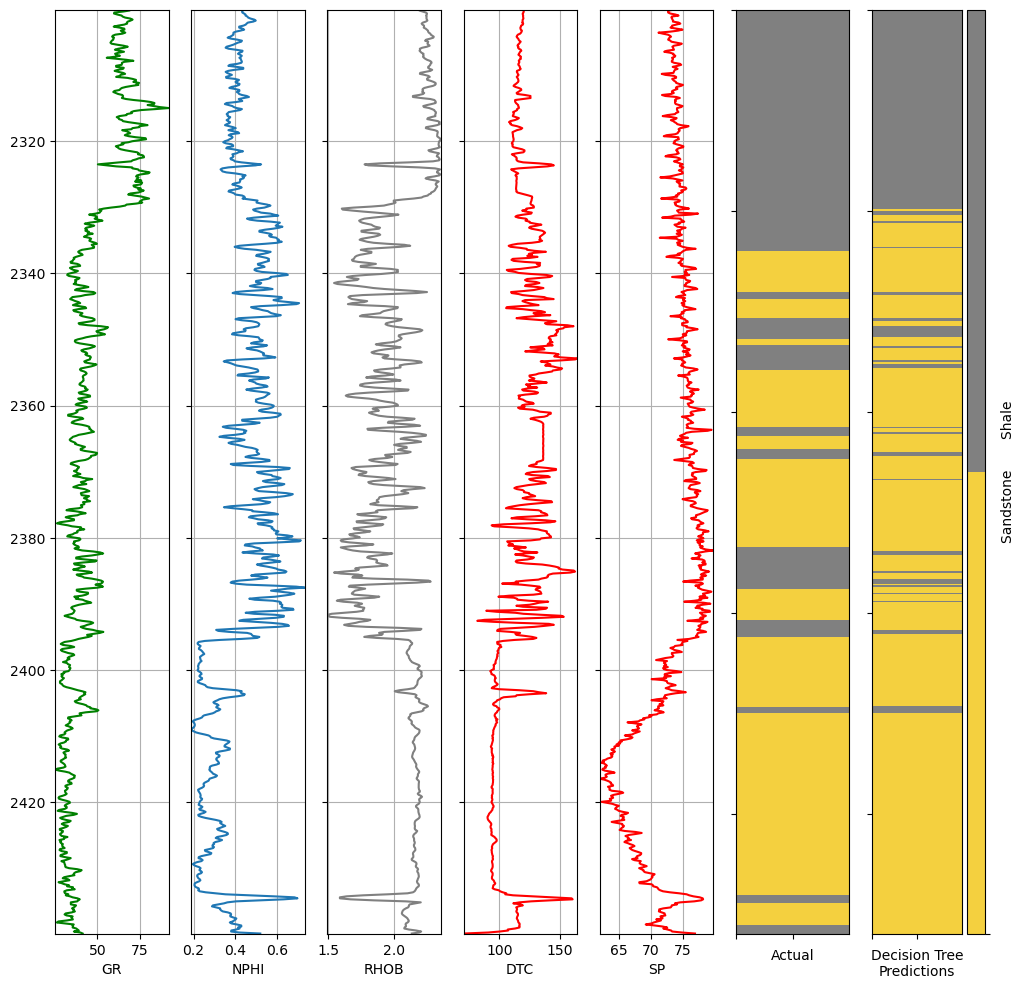

In [53]:
def compare_facies_log_plot(logs, x1, x2, x3, x4, x5):
    
    #logs = logs.fillna(0)        
    logs = logs.sort_values(by='DEPTH_MD', ascending=True)
    ztop = logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    facies_colors = [
        '#F4D03F', 'grey'
    ]

    facies_labels = [
        'Sandstone', 'Shale'
    ]

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    #no = len(list(dict(logs[target].value_counts())))
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['xgb_preds'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    ax[0].plot(logs[x1], logs.DEPTH_MD, '-g')
    ax[1].plot(logs[x2], logs.DEPTH_MD, '-')
    ax[2].plot(logs[x3], logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs[x4], logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs[x5], logs.DEPTH_MD, '-', color='r')
    im=ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    im=ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((7*' ').join([
        'Sandstone', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel(x1)
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), logs[x2].max())
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel(x5)
    ax[4].set_xlim(logs[x5].min(), logs[x5].max())
    ax[5].set_xlabel('Actual')
    ax[6].set_xlabel('Decision Tree\nPredictions')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); 
    
compare_facies_log_plot(section, 'GR', 'NPHI', 'RHOB', 'DTC', 'SP')

In [54]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

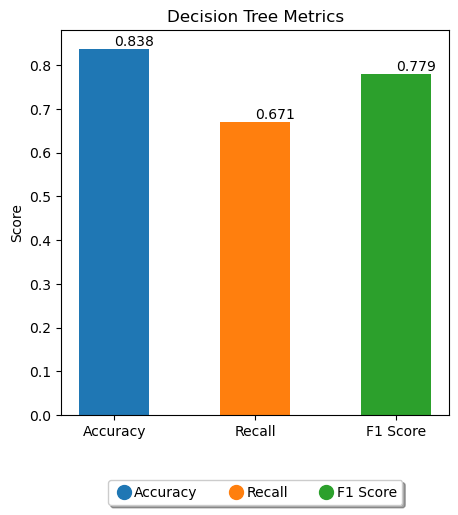

In [55]:
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = sklm.accuracy_score(labels, y_pred)
recall = sklm.recall_score(labels, y_pred)
f1_score = sklm.f1_score(labels, y_pred)

# Create a list of metrics
metrics = [accuracy, recall, f1_score]

# Create a list of metric names
metric_names = ['Accuracy', 'Recall', 'F1 Score']

# Set up colors
colors = ['C0', 'C1', 'C2']

# Create the bar plot
plt.figure(figsize=(5,5))
bars = plt.bar(metric_names, metrics, color=colors, width=0.5)

# Add a title
plt.title('Decision Tree Metrics')

# Add y label
plt.ylabel('Score')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom') # va: vertical alignment

# Add legends for colors
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(metric_names[i]) )[0]  for i in range(len(metric_names))]
plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.15), 
            loc='upper center', ncol=len(metric_names), 
            columnspacing=2.0, handletextpad=0.0, handlelength=1.5,
            fancybox=True, shadow=True)

# Show the plot
plt.show()


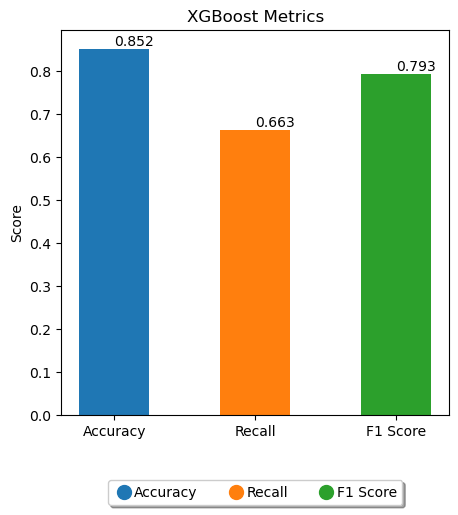

In [56]:
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = sklm.accuracy_score(labels, xgb_pred)
recall = sklm.recall_score(labels, xgb_pred)
f1_score = sklm.f1_score(labels, xgb_pred)

# Create a list of metrics
metrics = [accuracy, recall, f1_score]

# Create a list of metric names
metric_names = ['Accuracy', 'Recall', 'F1 Score']

# Set up colors
colors = ['C0', 'C1', 'C2']

# Create the bar plot
plt.figure(figsize=(5,5))
bars = plt.bar(metric_names, metrics, color=colors, width=0.5)

# Add a title
plt.title('XGBoost Metrics')

# Add y label
plt.ylabel('Score')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom') # va: vertical alignment

# Add legends for colors
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(metric_names[i]) )[0]  for i in range(len(metric_names))]
plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.15), 
            loc='upper center', ncol=len(metric_names), 
            columnspacing=2.0, handletextpad=0.0, handlelength=1.5,
            fancybox=True, shadow=True)

# Show the plot
plt.show()


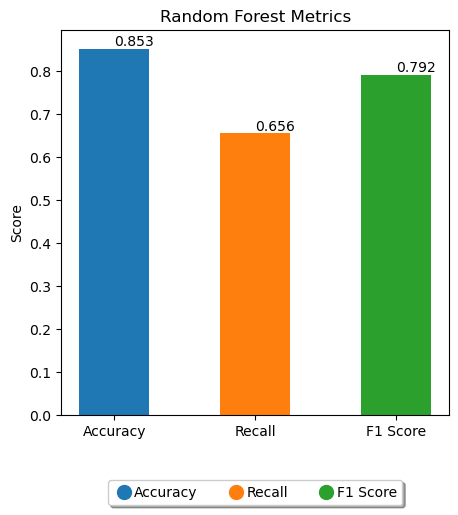

In [57]:
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = sklm.accuracy_score(labels, pred)
recall = sklm.recall_score(labels, pred)
f1_score = sklm.f1_score(labels, pred)

# Create a list of metrics
metrics = [accuracy, recall, f1_score]

# Create a list of metric names
metric_names = ['Accuracy', 'Recall', 'F1 Score']

# Set up colors
colors = ['C0', 'C1', 'C2']

# Create the bar plot
plt.figure(figsize=(5,5))
bars = plt.bar(metric_names, metrics, color=colors, width=0.5)

# Add a title
plt.title('Random Forest Metrics')

# Add y label
plt.ylabel('Score')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom') # va: vertical alignment

# Add legends for colors
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(metric_names[i]) )[0]  for i in range(len(metric_names))]
plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.15), 
            loc='upper center', ncol=len(metric_names), 
            columnspacing=2.0, handletextpad=0.0, handlelength=1.5,
            fancybox=True, shadow=True)

# Show the plot
plt.show()


## Conclusion
* The Extreme Gradient Boosting algorithm performs better than the decision tree and random forest algorithms with an accuracy of 83.8%
* 
The machine learning approach successfully predicted more than 80% of the test dataset correct
* The model could be improved with increasing the amount of training and test datasetaset
